# Project Overview

Sparkify is a music streaming service provider. Users can listen to music for free or to subscribe. Users can upgrade, downgrade, or cancel their subscription. My task is to predict the user who is going to leave in order to offer him a discount before canceling the subscription.

To find out the user preference is vital to the business growth. At the same time, we also want to find out the user who choose to cancel the subsription. We define those users as `churn users`.

In this project, the goal is to predict the churn users using machine learning technologies and to do a analysis on users behaviors.

#### Other Information:

1. This perject contains a tiny subset (128MB) of the full dataset available (12GB).
2. Tech Stack: python, pyspark, pandas, sql, sklearn

# Problem statement

Sparkify recorded key user behaviors while user interacte in the platform. To retain users and improve the service, we hope to predict user who will 'churn'. We define that user who unsubscribe the service as churned users.

`churn users` will be labeled as `1`, and other users are labeled as `0`. Machine learning technology is used in this project to predict the `churn users`.

# Project Structure

#### 1. Data Cleaning
#### 2. Exploratory Data Analysis
#### 3. Feature Engineering
#### 4. User Behavior and Churned Users Analysis
#### 5. Evaluation Metrics
#### 6. Modeling
#### 7. Evaluation
#### 8. Conclusion

In [1]:
!pip install lightgbm

    100% |████████████████████████████████| 2.0MB 11.9MB/s ta 0:00:01


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, countDistinct,first, last
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType,StringType ,DoubleType

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, split,
    first, last, 
    desc, asc,
    avg,
    count, countDistinct, approx_count_distinct,
    when, 
    isnull, isnan,
    from_unixtime, date_format, datediff,
    dayofmonth, month, hour, to_date,
    )

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import f1_score
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

import lightgbm as lgb
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC,
    NaiveBayes
)

from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

%matplotlib inline
from functools import reduce
from datetime import datetime
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [3]:
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, to_timestamp, from_unixtime, split, min, max, lit, mean
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring
from pyspark.sql.types import TimestampType

In [4]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load Dataset

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.count()

286500

# Data Cleaning

- Verify and remove missing values
- Conver time format
- Remove irrelevant columns
- Check duplicates


### 1. remove missing values

In [8]:
df.dropna(how = "any", subset = ["userId"]).count()

286500

Superfically, there not na in 'userId'. But after a closer look, I find that some 'userId' were filled in '' (empty string). So those rows should be remvoed.

In [9]:
df_cleaned = df.filter(df['userId']!='')

### 2. Convert the time format

In [10]:
df_cleaned = df_cleaned.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
df_cleaned = df_cleaned.withColumn('date', to_date('tsDate'))
df_cleaned = df_cleaned.withColumn('registrationtsDate', (col('registration') / 1000.0).cast(TimestampType()))
df_cleaned = df_cleaned.withColumn('registration_date', to_date('registrationtsDate'))

In [11]:
# this triggers bug
# # Create a user defined function for formating the timestamp
# convert_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# #Apply the udf on the ts column
# df_cleaned = df_cleaned.withColumn("time", convert_time(df_cleaned.ts))

### 3. remove irrelevant columns

As I don't need 'firstName' and 'lastName' columns, they are removed.

In [12]:
df_cleaned = df_cleaned.drop(*['firstName', 'lastName'])

### 4. check duplicates

In [13]:
print(f'Duplicate rows: {df_cleaned.count() - df_cleaned.dropDuplicates().count()}')

Duplicate rows: 0


In [14]:
df_cleaned.createOrReplaceTempView("Sparkify_cleaned")

In [15]:
df_cleaned.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 0, 1, 57), date=datetime.date(2018, 10, 1), registrationtsDate=datetime.datetime(2018, 9, 28, 22, 22, 42), registration_date=datetime.date(2018, 9, 28))

# Exploratory Data Analysis

### Define Churn
A Column `Churn` is created to use as the label for model later. `Cancellation Confirmation` events is used to define the churn, which happen for both paid and free users.

### Explore Data
In this session, I perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

- Time span
- Gender, session, user number, web page interactions
- Check suspicious activities (bot access)

### The time frame of the users being analysed

In [16]:
spark.sql('''
    select min(tsDate) start, max(tsDate) end
    from Sparkify_cleaned
''').show()

+-------------------+-------------------+
|              start|                end|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+



### The category of genders

In [17]:
spark.sql('''
    SELECT DISTINCT(gender)
    FROM Sparkify_cleaned
''').show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



### the number of unique users and sessions

In [18]:
# check the number of unique users
spark.sql('''
    SELECT count(distinct userId) as unique_users
    FROM Sparkify_cleaned
''').show()

+------------+
|unique_users|
+------------+
|         225|
+------------+



In [19]:
# check the number of unique sessionId
spark.sql('''
    SELECT count(distinct sessionId) as unique_sessions
    FROM Sparkify_cleaned
''').show()

+---------------+
|unique_sessions|
+---------------+
|           2312|
+---------------+



### the distribution of male and female users

In [20]:
gender_count = spark.sql('''
    SELECT gender,COUNT(DISTINCT userId) AS user_counts
    FROM Sparkify_cleaned
    GROUP BY gender
    ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



In [21]:
# check the page logs
spark.sql('''
    SELECT page, count(page) amount
    FROM Sparkify_cleaned
    group by page
    order by amount desc
''').show()

+--------------------+------+
|                page|amount|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



`NextSong` is the most common behavior in the page.

`Cancellation Confirmation` events were the least among those behaviors.

In [22]:
# check the log times by genders
spark.sql('''
    SELECT gender, count(gender) amount
    FROM Sparkify_cleaned
    group by gender
''').show()

+------+------+
|gender|amount|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



Although there are more male users than female, the log times of female is greater than that of the male.

In [23]:
cancel_label = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_churn = df_cleaned.withColumn('cancel_page',cancel_label('page'))
windowval = Window.partitionBy('userId')
df_churn = df_churn.withColumn('churn',Fsum('cancel_page').over(windowval))

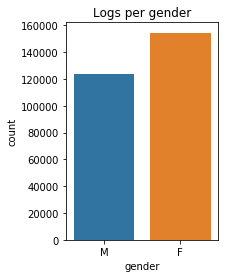

In [24]:
df_gender_logs = df_churn.select('gender').toPandas()
plt.subplot(1, 2, 1)
sns.countplot(data = df_gender_logs, x = 'gender', order = ['M','F']).set_title('Logs per gender');

In [25]:
df_churn.groupby('userId').count().toPandas().describe()

,count
count,225.000000
mean,1236.240000
std,1329.531716
min,6.000000
25%,296.000000
50%,848.000000
75%,1863.000000
max,9632.000000


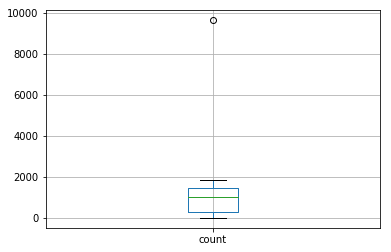

In [26]:
df_churn.groupby('userId').count().toPandas().describe().boxplot()

From the box plot, there are a few abnormalties. 
Those data points may cause data shift, it is safer to remove them.

Before removing it, let's have a look of the user with most manipulation. 
This record is suspicious, and it might be a bot.

In [27]:
# we can see the userId is 39.
df_churn.groupby('userId').count().toPandas().sort_values('count', ascending=False)[:10]

,userId,count
191,39,9632
127,92,7230
69,140,6880
89,300011,5732
4,124,4825
182,300021,4659
15,300017,4428
39,85,4370
19,42,4257
125,200023,3769


In [28]:
gender_count = spark.sql('''
    SELECT date, COUNT(date) AS date_counts
    FROM Sparkify_cleaned
    where userId = 39
    GROUP BY date
    ORDER BY date
''')
gender_count.show()

+----------+-----------+
|      date|date_counts|
+----------+-----------+
|2018-10-01|        109|
|2018-10-02|        144|
|2018-10-03|         33|
|2018-10-04|        106|
|2018-10-05|         55|
|2018-10-06|         98|
|2018-10-07|          8|
|2018-10-08|         59|
|2018-10-09|        337|
|2018-10-10|         76|
|2018-10-11|        188|
|2018-10-12|        155|
|2018-10-13|        338|
|2018-10-14|        175|
|2018-10-15|        307|
|2018-10-16|        227|
|2018-10-17|        207|
|2018-10-18|        221|
|2018-10-19|        261|
|2018-10-20|        411|
+----------+-----------+
only showing top 20 rows



In [29]:
import datetime
temp = df_churn[df_churn['userId'] == 39].toPandas()
temp[temp['date']== datetime.date(2018, 10, 1)][['page','tsDate']]

,page,tsDate
0,Home,2018-10-01 06:35:48
1,NextSong,2018-10-01 06:35:52
2,NextSong,2018-10-01 06:39:12
3,NextSong,2018-10-01 06:45:32
4,Roll Advert,2018-10-01 06:46:16
5,NextSong,2018-10-01 06:49:17
6,NextSong,2018-10-01 06:52:34
7,NextSong,2018-10-01 06:57:12
8,Roll Advert,2018-10-01 06:57:59
9,NextSong,2018-10-01 07:04:11


In [30]:
temp2 = df_churn[df_churn['userId'] == 39].toPandas()
temp2[temp2['date']== datetime.date(2018, 10, 2)][['page','tsDate']]

,page,tsDate
109,NextSong,2018-10-02 00:02:21
110,NextSong,2018-10-02 00:07:04
111,Upgrade,2018-10-02 00:07:22
112,NextSong,2018-10-02 06:59:22
113,NextSong,2018-10-02 07:03:19
114,Roll Advert,2018-10-02 07:04:30
115,NextSong,2018-10-02 07:07:02
116,Roll Advert,2018-10-02 07:07:22
117,NextSong,2018-10-02 07:10:57
118,NextSong,2018-10-02 07:14:49


In [31]:
temp3 = df_churn[df_churn['userId'] == 39].toPandas()
temp3[temp3['date']== datetime.date(2018, 10, 3)][['page','tsDate']]

,page,tsDate
253,Home,2018-10-03 07:30:21
254,NextSong,2018-10-03 07:30:26
255,NextSong,2018-10-03 07:34:46
256,NextSong,2018-10-03 07:39:48
257,NextSong,2018-10-03 07:44:06
258,Logout,2018-10-03 07:44:07
259,Home,2018-10-03 07:44:25
260,Home,2018-10-03 11:51:20
261,NextSong,2018-10-03 11:52:59
262,Roll Advert,2018-10-03 11:53:35


### After a detailed examination, I am sure this is not a bot.

### That the user spent a lot of time listening to music everyday.

##### (To save time, I don't examine all the users with a above mean log number)

In [32]:
rare_users = df_churn.groupby('userId').count().toPandas().sort_values('count', ascending=False).reset_index()

rare_users.drop('index', axis=1, inplace=True)

In [33]:
rare_users_id_list = list(rare_users[rare_users['count'] >= 3000].userId.values)

In [34]:
df_churn = df_churn.filter(~df_churn.userId.isin(rare_users_id_list))

In [35]:
df_churn.count()

195999

# --- Todo： work day analysis ---

In [36]:
# def generate_date_features(df: pd.DataFrame) -> pd.DataFrame:
#     tmp_datetime = df.tsDate
#     df['hour'] = tmp_datetime.dt.hour
#     df['day'] = tmp_datetime.dt.day
#     df['day_of_week'] = tmp_datetime.dt.dayofweek
#     df['week'] = tmp_datetime.dt.isocalendar().week
#     df['month'] = tmp_datetime.dt.month
#     return df


# fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
# fig.set_size_inches(18,30)

# hourAggregated = pd.DataFrame(train.groupby(["hour","day_of_week"],sort=True)["count"].mean()).reset_index()
# sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["day_of_week"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
# ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

# --- Todo： work day analysis ---

# Feature Engineering 1

In [37]:
# Feature engineering that aggreagtes the user behaviors under one user id.

def build_features(df):
    """
    this funtion aggreate all the user events under each user.
    """
    df_user_level = df.groupBy("userId") \
        .agg( 
            count(when(col("page") == "NextSong", True)).alias("user_songs"),
            # count user's individual actions using all page visits
            count(when(col("page") == "Thumbs Up", True)).alias("user_likes"),
            count(when(col("page") == "Thumbs Down", True)).alias("user_dislikes"),
    
            count(when(col("page") == "Add to Playlist", True)).alias("user_playlist"),
            count(when(col("page") == "Add Friend", True)).alias("user_friends"),
    
            count(when(col("page") == "Downgrade", True)).alias("user_downgrades"),
            count(when(col("page") == "Upgrade", True)).alias("user_upgrades"),
    
            count(when(col("page") == "Home", True)).alias("user_home"),
            count(when(col("page") == "Error", True)).alias("user_error"),
            count(when(col("page") == "Settings", True)).alias("user_settings"),
    
            count(when(col("page") == "Roll Advert", True)).alias("user_ads"),
    
            # compute the number of sessions a user is in
            countDistinct("sessionId").alias("user_sessions"),
    
            # find the total number of actions a user took
            countDistinct("itemInSession").alias("user_acts"),
    
            # compute the average number of page actions per sesssion
            (countDistinct("itemInSession")/countDistinct("sessionId")).alias("acts_per_session"),
    
            # compute the average number of songs per session
            (count(when(col("page") == "NextSong",
                        True))/countDistinct("sessionId")).alias("songs_per_session"),
    
            # compute the average number of songs per day
            (count(when(col("page") == "NextSong",
                        True))/countDistinct("date")).alias("songs_per_day"),
        
            # compute the average length of songs the user listen
            (Fsum('length')/count(when(col("page") == "NextSong",
                        True))).alias("ave_song_length"),
            
            # compute the average number of ads per session
            (count(when(col("page") == "Roll Advert",
                        True))/countDistinct("sessionId")).alias("ads_per_session"),
            
        
            # encode the gender 1 for F and 0 for M
            first(when(col("gender") == "F", 1).otherwise(0)).alias("gender"),
    
            # encode the level (paid/free) according to the last record
            last(when(col("level") == "paid", 1).otherwise(0)).alias("level"),
    
            # flag those users that downgraded 
            last(when(col("page") == "Downgrade", 1).otherwise(0)).alias("downgrade"),
    
            # create the churn column that records if the user cancelled 
            last(when(col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn")
            )

    df_user_level = df_user_level.drop("userId")   
    
    return df_user_level

df_user_level = build_features(df_churn)

In [38]:
df_user_level.toPandas().head()

,user_songs,user_likes,user_dislikes,user_playlist,user_friends,user_downgrades,user_upgrades,user_home,user_error,user_settings,...,user_acts,acts_per_session,songs_per_session,songs_per_day,ave_song_length,ads_per_session,gender,level,downgrade,churn
0,275,17,5,7,4,0,2,11,0,0,...,112,16.000000,39.285714,39.285714,243.421445,7.428571,1,0,0,0
1,387,21,6,8,4,5,2,20,0,3,...,158,26.333333,64.500000,55.285714,242.916992,1.166667,0,1,0,0
2,8,0,0,0,0,0,0,0,0,0,...,11,11.000000,8.000000,8.000000,261.139138,1.000000,0,0,0,1
3,2111,100,21,52,28,23,0,75,1,12,...,613,61.300000,211.100000,162.384615,247.880551,0.000000,0,1,0,1
4,150,7,1,5,1,0,2,10,1,3,...,93,13.285714,21.428571,18.750000,253.560581,2.285714,0,0,0,0


# User behavior and Churn analysis

In this session, churn and not churn users will be compared analyzed.

# `songs_per_day` for Churn and Not Churn users

Text(0,0.5,'Ave songs Everydays')

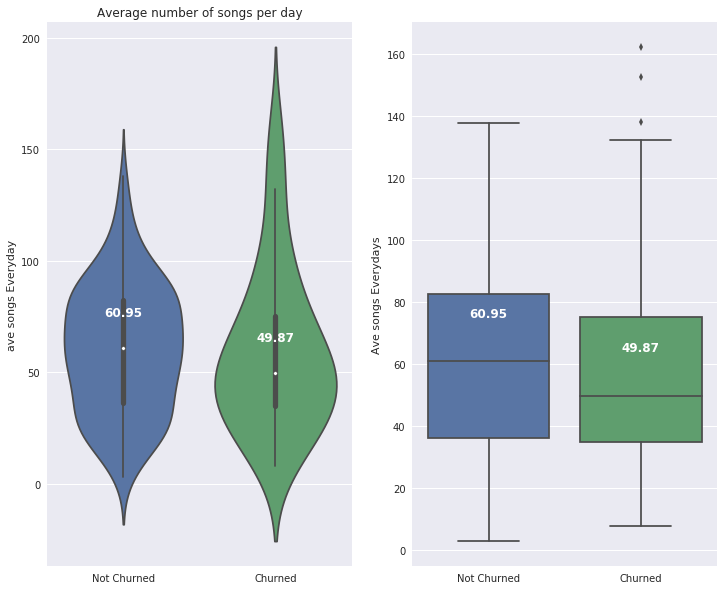

In [39]:
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

plt.subplot(1,2,1)
# plot two violinplots
ax1 = sns.violinplot(x='churn', y = 'songs_per_day', 
                 data = df_user_level.toPandas())

# label the median lines
medians = round(df_user_level.toPandas().groupby(['churn'])['songs_per_day'].median(), 2)
vertical_offset = df_user_level.toPandas()['songs_per_day'].median() * 0.25 # offset from median

for xtick in ax1.get_xticks():
    ax1.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average number of songs per day')
ax1.set(xticklabels=['Not Churned', 'Churned'])
ax1.set_xlabel("")
ax1.set_ylabel("ave songs Everyday")


plt.subplot(1,2,2)
ax2 = sns.boxplot(x='churn', y = 'songs_per_day', 
                 data = df_user_level.toPandas())

for xtick in ax2.get_xticks():
    ax2.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")
    
ax2.set(xticklabels=['Not Churned', 'Churned'])
ax2.set_xlabel("")
ax2.set_ylabel("Ave songs Everydays")

# `ave_song_length` for Churn and Not Churn users

Text(0,0.5,'Time for songs Everydays')

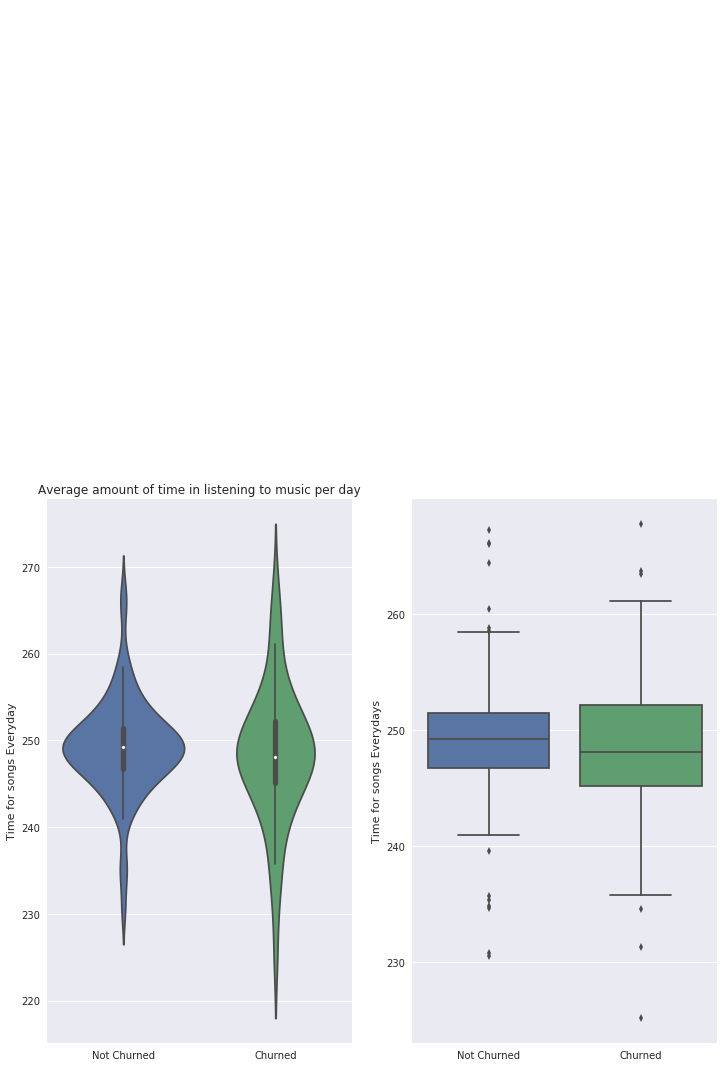

In [40]:
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

plt.subplot(1,2,1)
# plot two violinplots
ax1 = sns.violinplot(x='churn', y = 'ave_song_length', 
                 data = df_user_level.toPandas())

# label the median lines
medians = round(df_user_level.toPandas().groupby(['churn'])['ave_song_length'].median(), 2)
vertical_offset = df_user_level.toPandas()['ave_song_length'].median() * 0.25 # offset from median

for xtick in ax1.get_xticks():
    ax1.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average amount of time in listening to music per day')
ax1.set(xticklabels=['Not Churned', 'Churned'])
ax1.set_xlabel("")
ax1.set_ylabel("Time for songs Everyday")


plt.subplot(1,2,2)
ax2 = sns.boxplot(x='churn', y = 'ave_song_length', 
                 data = df_user_level.toPandas())

for xtick in ax2.get_xticks():
    ax2.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")
    
ax2.set(xticklabels=['Not Churned', 'Churned'])
ax2.set_xlabel("")
ax2.set_ylabel("Time for songs Everydays")

# `ads_per_session` for Churn and Not Churn users

Text(0,0.5,'Count of Ads')

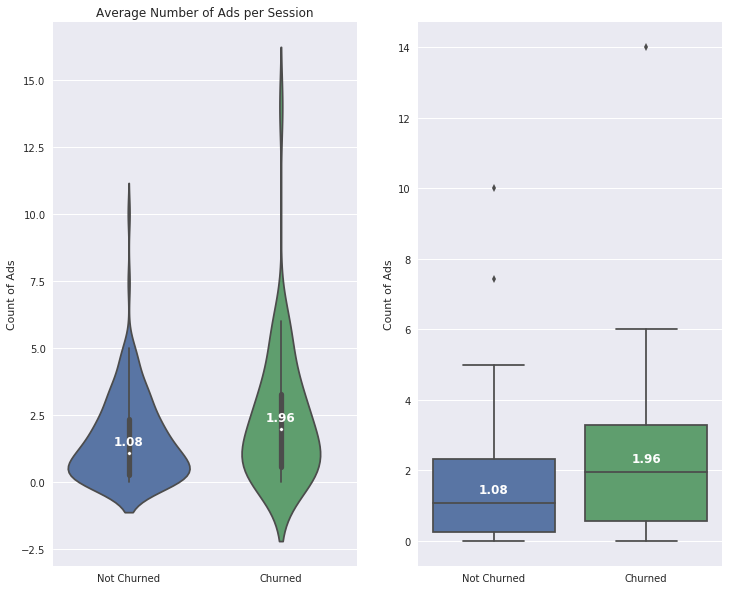

In [41]:
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

plt.subplot(1,2,1)
# plot two violinplots
ax1 = sns.violinplot(x='churn', y = 'ads_per_session', 
                 data = df_user_level.toPandas())

# label the median lines
medians = round(df_user_level.toPandas().groupby(['churn'])['ads_per_session'].median(), 2)
vertical_offset = df_user_level.toPandas()['ads_per_session'].median() * 0.25 # offset from median

for xtick in ax1.get_xticks():
    ax1.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Ads per Session')
ax1.set(xticklabels=['Not Churned', 'Churned'])
ax1.set_xlabel("")
ax1.set_ylabel("Count of Ads")


plt.subplot(1,2,2)
ax2 = sns.boxplot(x='churn', y = 'ads_per_session', 
                 data = df_user_level.toPandas())

for xtick in ax2.get_xticks():
    ax2.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")
    
ax2.set(xticklabels=['Not Churned', 'Churned'])
ax2.set_xlabel("")
ax2.set_ylabel("Count of Ads")

Note:
A violin plot is two KDE plots aligned on an axis. The "negative" values you are seeing are just an artifact of KDEs. They are estimations of values in your data. It's not saying you have negative data, it's saying that your data contains values very close to negative values, namely 0. And thus you have a non-zero estimated probability of selecting a negative value from your dataset.

From the box plot, we can see that the churn users obviously received more advertisements, but the violin plot shows that there were many churn users distributed in receiving 0 ads. This indicates that they leave the platfrom before they had stayed enough time to receive an ad.

# `songs_per_session` for Churn and Not Churn users

Text(0,0.5,'Count of Songs')

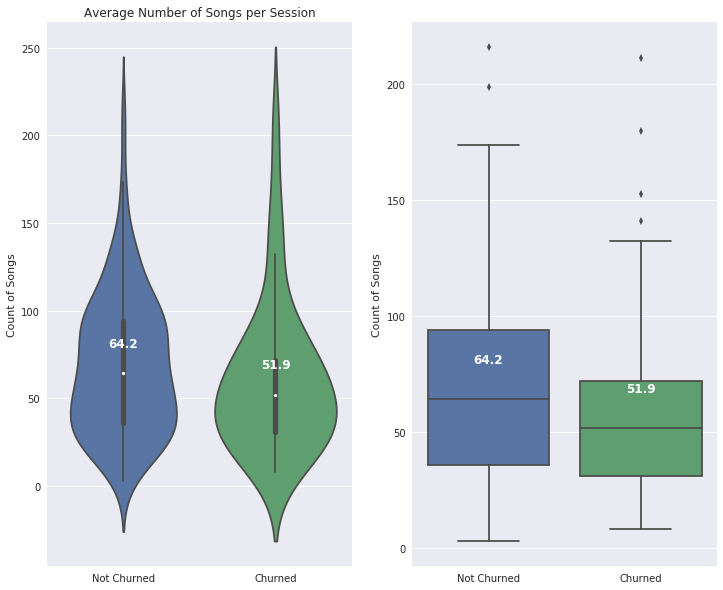

In [42]:
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

plt.subplot(1,2,1)
# plot two violinplots
ax1 = sns.violinplot(x='churn', y = 'songs_per_session', 
                 data = df_user_level.toPandas())

# label the median lines
medians = round(df_user_level.toPandas().groupby(['churn'])['songs_per_session'].median(), 2)
vertical_offset = df_user_level.toPandas()['songs_per_session'].median() * 0.25 # offset from median

for xtick in ax1.get_xticks():
    ax1.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Songs per Session')
ax1.set(xticklabels=['Not Churned', 'Churned'])
ax1.set_xlabel("")
ax1.set_ylabel("Count of Songs")


plt.subplot(1,2,2)
ax2 = sns.boxplot(x='churn', y = 'songs_per_session', 
                 data = df_user_level.toPandas())

for xtick in ax2.get_xticks():
    ax2.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")
    
ax2.set(xticklabels=['Not Churned', 'Churned'])
ax2.set_xlabel("")
ax2.set_ylabel("Count of Songs")

Intuitively, users stayed overall listened more songs than those churned. Numerically, churn users also listened many songs.

The shapes of the distributions of the two groups of users are similar. 

# `acts_per_session` for Churn and Not Churn users

Text(0,0.5,'Count of Acts')

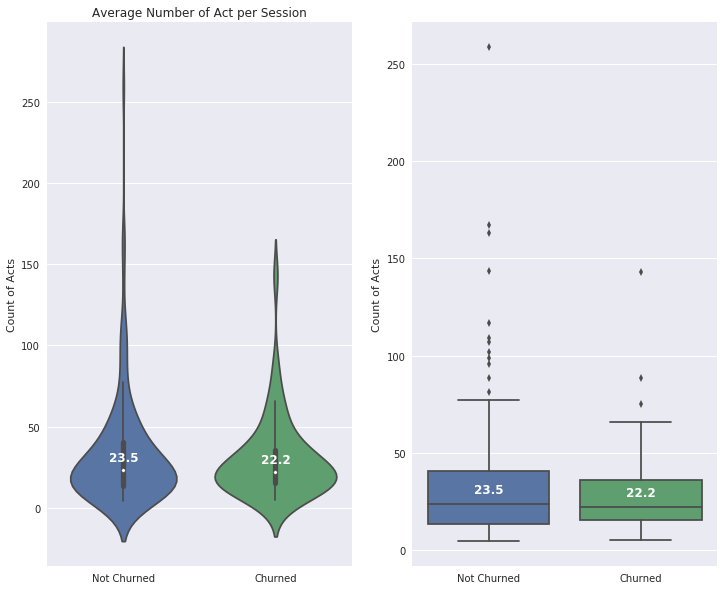

In [43]:
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

plt.subplot(1,2,1)
# plot two violinplots
ax1 = sns.violinplot(x='churn', y = 'acts_per_session', 
                 data = df_user_level.toPandas())

# label the median lines
medians = round(df_user_level.toPandas().groupby(['churn'])['acts_per_session'].median(), 2)
vertical_offset = df_user_level.toPandas()['acts_per_session'].median() * 0.25 # offset from median

for xtick in ax1.get_xticks():
    ax1.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Act per Session')
ax1.set(xticklabels=['Not Churned', 'Churned'])
ax1.set_xlabel("")
ax1.set_ylabel("Count of Acts")


plt.subplot(1,2,2)
ax2 = sns.boxplot(x='churn', y = 'acts_per_session', 
                 data = df_user_level.toPandas())

for xtick in ax2.get_xticks():
    ax2.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")
    
ax2.set(xticklabels=['Not Churned', 'Churned'])
ax2.set_xlabel("")
ax2.set_ylabel("Count of Acts")

If the outliers were removed, the distributions of the two groups are similar. The median of the two groups are close.

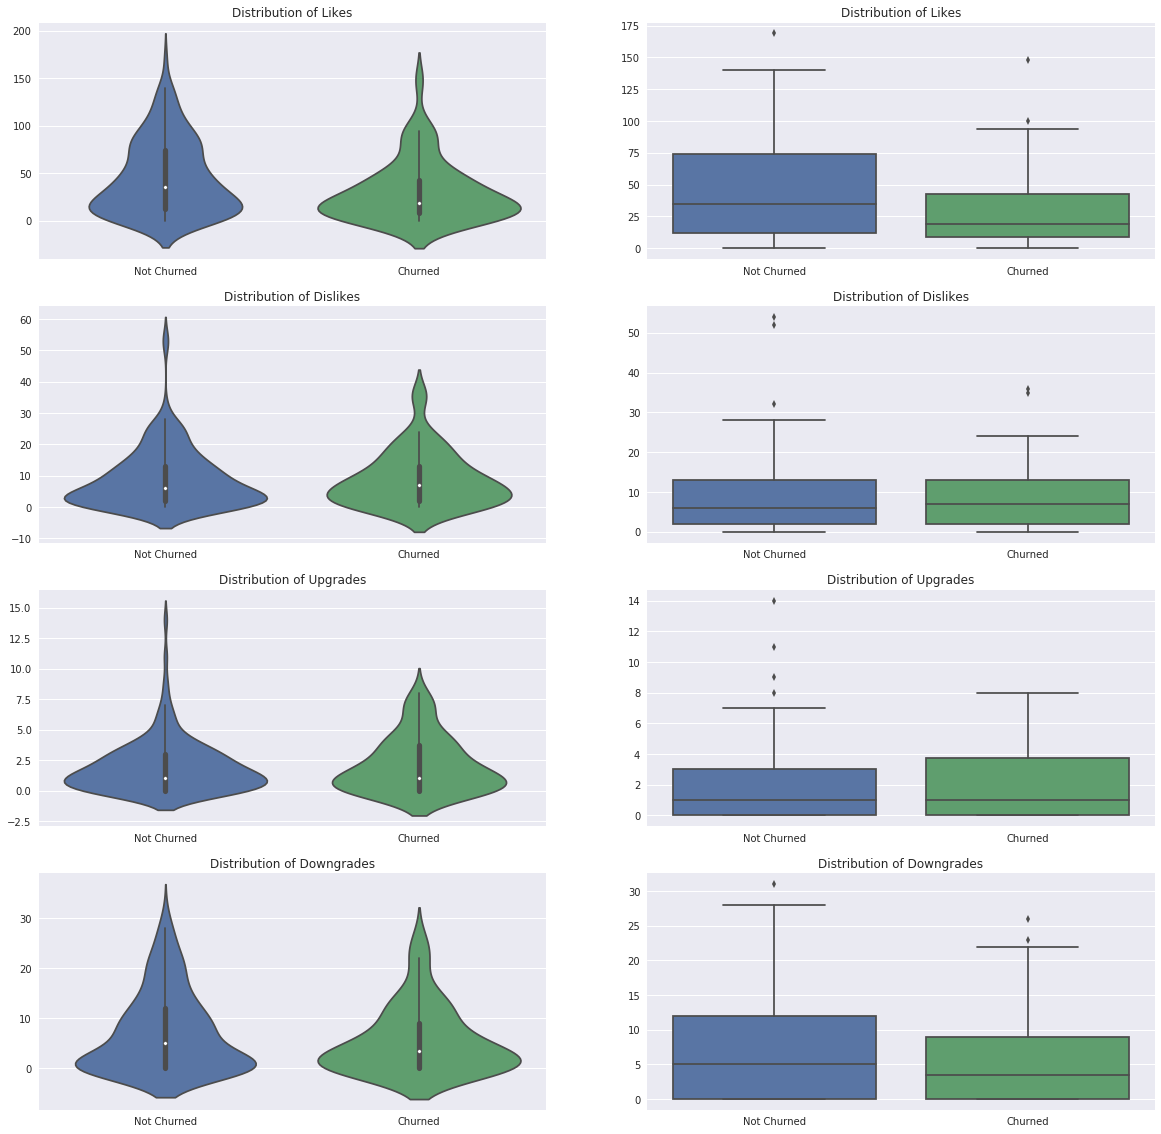

In [44]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(20,20)})
sns.set(font_scale=1)

# tick labels for x-axis
xticklabels = ['Not Churned', 'Churned'];

# plot on first row on left
plt.subplot(4,2,1)
ax1=sns.violinplot(x="churn", y="user_likes",data=df_user_level.toPandas());

plt.title("Distribution of Likes");
plt.xlabel("")
plt.ylabel("");
ax1.set_xticks([0, 1])
ax1.set_xticklabels(xticklabels);

plt.subplot(4,2,2)
ax2=sns.boxplot(x="churn", y="user_likes",data=df_user_level.toPandas());

plt.title("Distribution of Likes");
plt.xlabel("")
plt.ylabel("");
ax2.set_xticks([0, 1])
ax2.set_xticklabels(xticklabels);

# plot on first row on right
plt.subplot(4,2,3)
ax3=sns.violinplot(x="churn", y="user_dislikes",data=df_user_level.toPandas());

plt.title("Distribution of Dislikes");
plt.xlabel("")
plt.ylabel("");
ax3.set_xticks([0, 1])
ax3.set_xticklabels(xticklabels);

plt.subplot(4,2,4)
ax4=sns.boxplot(x="churn", y="user_dislikes",data=df_user_level.toPandas());

plt.title("Distribution of Dislikes");
plt.xlabel("")
plt.ylabel("");
ax4.set_xticks([0, 1])
ax4.set_xticklabels(xticklabels);

# plot on second row on left
plt.subplot(4,2,5)
ax5=sns.violinplot(x='churn', y='user_upgrades',data=df_user_level.toPandas());

plt.title("Distribution of Upgrades");
plt.xlabel("")
plt.ylabel("");
ax5.set_xticks([0, 1])
ax5.set_xticklabels(xticklabels);

plt.subplot(4,2,6)
ax6=sns.boxplot(x='churn', y='user_upgrades',data=df_user_level.toPandas());

plt.title("Distribution of Upgrades");
plt.xlabel("")
plt.ylabel("");
ax6.set_xticks([0, 1])
ax6.set_xticklabels(xticklabels);

# plot on second row on right
plt.subplot(4,2,7)
ax7=sns.violinplot(x="churn", y='user_downgrades',data=df_user_level.toPandas());

plt.title("Distribution of Downgrades");
plt.xlabel("")
plt.ylabel("");
ax7.set_xticks([0, 1])
ax7.set_xticklabels(xticklabels);

plt.subplot(4,2,8)
ax8=sns.boxplot(x="churn", y='user_downgrades',data=df_user_level.toPandas());

plt.title("Distribution of Downgrades");
plt.xlabel("")
plt.ylabel("");
ax8.set_xticks([0, 1])
ax8.set_xticklabels(xticklabels);

In [45]:
# df_user_level.groupBy(['churn']).sum('next_songs').show()

In [46]:
# # check the user levels
# temp = df_churn.groupBy(['churn','level']).agg(countDistinct('userId'))
# temp.show()

In [47]:
# # check the gender
# df_churn.dropDuplicates(['userId']).groupby(['churn', 'gender']).count().show()

In [48]:
### Distribution of Churn on Page
# # check the page
# df_churn.select(["churn", "page"]).groupby(["churn", "page"]).count().sort("page").show()

In [49]:
# def normalize_data(groupby_data):
#     groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
#     temp = groupby_series.unstack('Churn').fillna(0)
#     df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
#     df = df.rename(columns={df.columns[-1]:'result'})
#     return df

In [50]:
# page = df_churn.select(["page","Churn"]).groupby([ "page","Churn"]).count().toPandas()
# page = normalize_data(page)
# fig, ax = plt.subplots(figsize=(8,8))
# sns.barplot(x=page.result, y=page.page, hue=page.Churn, data=page, ax=ax)

# Heat Map checking the feature relevance

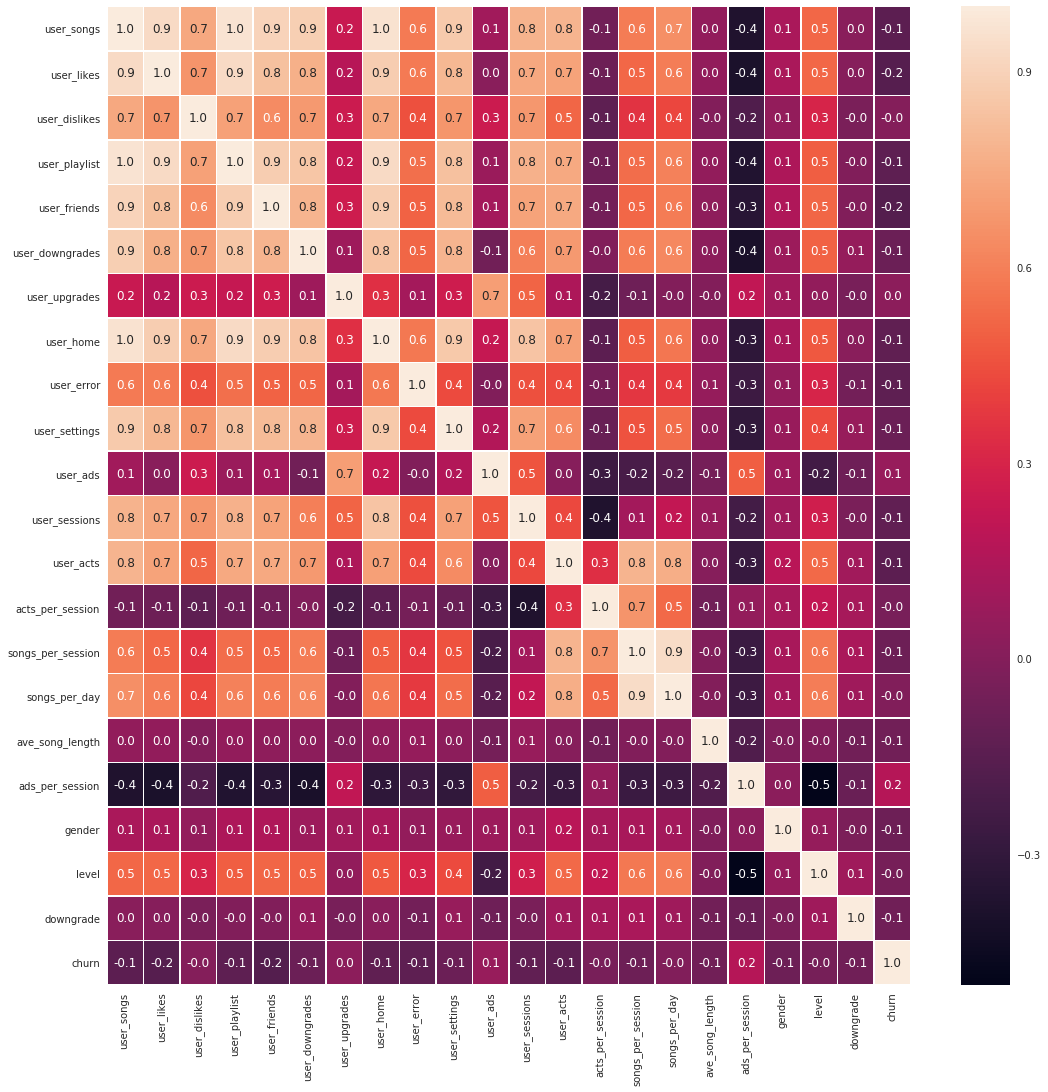

In [51]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_user_level.toPandas().corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

From the heat map, `next_songs`, `user_palylist` and `user_home` are highly correlated among all the features. I first try to remove `user_home` and `user_palylist`.

## Kendall Rank Correlation Coefficient


As the user behavior data to `churn` is non-parametric correlated, I use kendall, not pearson correlation, to examine the data.

In [52]:
kendall_corr = df_user_level.toPandas().corr(method='kendall')

In [53]:
churn_kendall_corr = pd.DataFrame(kendall_corr['churn']).reset_index()
churn_kendall_corr.columns = ['features', 'kendall_val']

In [54]:
churn_kendall_corr.sort_values('kendall_val')

,features,kendall_val
1,user_likes,-0.131075
4,user_friends,-0.129847
12,user_acts,-0.117817
0,user_songs,-0.109797
11,user_sessions,-0.100870
8,user_error,-0.100035
3,user_playlist,-0.099596
7,user_home,-0.097646
14,songs_per_session,-0.092383
18,gender,-0.083996


From the table we can see that `user_dislikes` and `user_upgrades` have least correlations among those features with `churn`.

# Metrics

- Confusion Matrix
- Precision and Recall
- F1 score

#### Confusion Matrix

This project is a supervised machine learning classification task, there will be TP, FP, FN, TN - four different prediction outcomes.

A true positive(TP) is an outcome where the model correctly predicts the positive class. Similarly, a true negative(TN) is an outcome where the model correctly predicts the negative class.

A false positive(FP) is an outcome where the model incorrectly predicts the positive class. And a false negative(FN) is an outcome where the model incorrectly predicts the negative class.

Confusion Matrix gives us a clear view of TP, FP, FN, TN.

#### Precision and Recall

The `precision` indicates the number of real churn users be identified among the churn users identified by the algorithms.

$$precision = \frac{TP}{TP+FP}$$

The `recall` indicates the number of real churn users be identified among all actual churn users.

$$recall = \frac{TP}{TP+FN}$$

#### F1-SCORE

`F1-score` is the combination of `precision` and `reall`, it can indicate, in the extreme case, that model has bias.

$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$

# Modeling and Evaluation

1. split the dataset into train and test datasets
2. data standardisation
3. define matrics
4. init models
5. build training pipelines
6. train models and get evaluations


In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [56]:
pd_df_user_level = df_user_level.toPandas()

In [57]:
pd_df_user_level.head()

,user_songs,user_likes,user_dislikes,user_playlist,user_friends,user_downgrades,user_upgrades,user_home,user_error,user_settings,...,user_acts,acts_per_session,songs_per_session,songs_per_day,ave_song_length,ads_per_session,gender,level,downgrade,churn
0,275,17,5,7,4,0,2,11,0,0,...,112,16.000000,39.285714,39.285714,243.421445,7.428571,1,0,0,0
1,387,21,6,8,4,5,2,20,0,3,...,158,26.333333,64.500000,55.285714,242.916992,1.166667,0,1,0,0
2,8,0,0,0,0,0,0,0,0,0,...,11,11.000000,8.000000,8.000000,261.139138,1.000000,0,0,0,1
3,2111,100,21,52,28,23,0,75,1,12,...,613,61.300000,211.100000,162.384615,247.880551,0.000000,0,1,0,1
4,150,7,1,5,1,0,2,10,1,3,...,93,13.285714,21.428571,18.750000,253.560581,2.285714,0,0,0,0


In [60]:
pd_df_user_level.drop(['user_dislikes', 'user_upgrades'], axis=1, inplace=True)

In [79]:
def extract_training_features(data_frame, response=None):
    """
    Extract the features that will be used for model training
    
    Input:
            data_frame: the dataframe that stores the data
            response: an array that contains all the features
    Output:
            data_frame[response]: the dataframe with features required
    """
    if response is None:
        response = ['user_songs',
                     'user_likes',
#                      'user_dislikes',
                     'user_playlist',
                     'user_friends',
                     'user_downgrades',
#                      'user_upgrades',
                     'user_home',
                     'user_error',
                     'user_settings',
                     'user_ads',
                     'user_sessions',
                     'user_acts',
                     'acts_per_session',
                     'songs_per_session',
                     'songs_per_day',
                     'ave_song_length',
                     'ads_per_session',
                     'gender',
                     'level',
                     'downgrade']
        
    return data_frame[response]

In [80]:
def perform_data_splitting(data_frame):
    """
    input:
              data_frame: pandas dataframe
              response: string of response name [optional argument that could be used for naming variables or
              index y column]
    output:
              X_train: x training data
              X_test: x testing data
              y_train: y training data
              y_test: y testing data
    """

    label_data = data_frame['churn']
    train_data = extract_training_features(data_frame)

    x_train, x_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.3, random_state=42)
    return x_train, x_test, y_train, y_test

In [81]:
def data_standarization(x_train, x_test):
    """
    Standarize the non-categorical features
    
    input:
            x_train: pandas dataframe, the training data set
            y_train: pandas dataframe, the testing data set
            
    output:
            x_train: standarized x_train
            y_train: standarized y_train
    """
    
    categorical_feature = 'level'
    
    non_categorical_features = list(x_train.columns)
    non_categorical_features.remove('level')
    
    sc = StandardScaler()
    x_train[non_categorical_features] = sc.fit_transform(x_train[non_categorical_features])
    x_test[non_categorical_features] = sc.transform (x_test[non_categorical_features])
    
    return x_train, x_test
    

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [88]:
def model_evaluation_result(model_name, data):
    """
    print out the evaluation result and store them in a dictionary
    
    input:
            model_name: str
            data: 
                a list contains 
                    y_train: label data in train dataset
                    y_test: label data in test dataset
                    y_train_predictions: train dataset predictions 
                    y_test_predictions: test dataset predictions
    """
    y_train, y_test, y_train_predictions, y_test_predictions = data

    score1 = precision_score(y_train, y_train_predictions, average='binary')
    score2 = recall_score(y_train, y_train_predictions, average='binary')
    score3 = f1_score(y_train, y_train_predictions, average='binary')
    score4 = accuracy_score(y_train, y_train_predictions)
    mat_ = confusion_matrix(y_train, y_train_predictions)
    print('----------------------------------')
    
    print(model_name, ":")
    print('Training Process:')
    print(f'Precision_score: {"%.2f" % score1}')
    print(f'Recall_score: {"%.2f" % score2}')
    print(f'F1_score: {"%.2f" % score3}')
    print('confusion_matrix')
    print(mat_)
          
    score1 = precision_score(y_test, y_test_predictions, average='binary')
    score2 = recall_score(y_test, y_test_predictions, average='binary')
    score3 = f1_score(y_test, y_test_predictions, average='binary')
    score4 = accuracy_score(y_test, y_test_predictions)
    mat_ = confusion_matrix(y_test, y_test_predictions)
    
    print(model_name, ":")
    print('Testing process:')
    print(f'Accuracy_score: {"%.2f" % score4}')
    print(f'Precision_score: {"%.2f" % score1}')
    print(f'Recall_score: {"%.2f" % score2}')
    print(f'F1_score: {"%.2f" % score3}')
    print('confusion_matrix')
    print(mat_)
    return [score1, score2, score3]

In [89]:
def init_models():
    """
    model initiation
    
    input:
              None
    output:
              initiated cv_lrc, cv_clf, and rfc models
    """

    param_grid = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [4, 5, 100],
        'criterion': ['gini', 'entropy']
    }

    # cv_rfc
    # reference: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae
    rfc = RandomForestClassifier(random_state=42)
    cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
    
    param_grid= {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [4, 5, 100],
        'criterion': ['friedman_mse']
    }
    
    # cv_clf
    clf = GradientBoostingClassifier(random_state=42)
    cv_clf = GridSearchCV(clf, param_grid=param_grid, cv=5)
    
    # lrc
    lrc = LogisticRegression()


    # lgbm
    param_grid= {
        'objective':['binary'],
        'max_depth': [4, 5, 100],
    }
    
    lgbm=lgb.LGBMClassifier(random_state=42)
    cv_lgbm = GridSearchCV(lgbm, param_grid=param_grid, cv=5)
    return cv_rfc, cv_clf, lrc, cv_lgbm


In [90]:
def store_models(model_name, pth):
    """
    store models
    input:
            model
    output:
            None
    """
    joblib.dump(model_name, pth)

In [91]:
def train_models(data, models=None):
    """
    train, store model results: images + scores, and store models
    input:
            data: an array that contains data below
            1) x_train: x training data
            2) x_test: x testing data
            3) y_train: y training data
            4) y_test: y testing data
    output:
            model_dict: an dictionary storing the model names and the corresponding models
            key - model names - string
            value - model
    """
    if models is None:
        models = ['lrc', 'clf', 'rfc', 'lgbm']

    x_train, x_test, y_train, y_test = data
    x_train, x_test = data_standarization(x_train, x_test)
    
    model_dict = dict()
    model_result_dict = dict()
    cv_rfc, cv_clf, lrc, cv_lgbm = init_models()
    
    if 'lrc' in models:
        lrc.fit(x_train, y_train)
#         store_models(lrc, './models/logistic_model.pkl')
        model_dict['lrc'] = lrc

        y_train_predictions_lr = lrc.predict(x_train)
        y_test_predictions_lr = lrc.predict(x_test)
        data = [y_train, y_test, y_train_predictions_lr, y_test_predictions_lr]
        model_result_dict['lrc'] = model_evaluation_result('Logistic_Regression', data)

    if 'clf' in models:
        cv_clf.fit(x_train, y_train)
#         store_models(cv_clf.best_estimator_, './models/gb_model.pkl')
        model_dict['clf'] = cv_clf.best_estimator_

        y_train_predictions_gb = cv_clf.best_estimator_.predict(x_train)
        y_test_predictions_gb = cv_clf.best_estimator_.predict(x_test)
        data = [y_train, y_test, y_train_predictions_gb, y_test_predictions_gb]
        model_result_dict['clf'] = model_evaluation_result('Gradient_Boosting', data)
        
    if 'rfc' in models:
        cv_rfc.fit(x_train, y_train)
#         store_models(cv_rfc.best_estimator_, './models/rfc_model.pkl')
        model_dict['rfc'] = cv_rfc.best_estimator_

        y_train_predictions_rf = cv_rfc.best_estimator_.predict(x_train)
        y_test_predictions_rf = cv_rfc.best_estimator_.predict(x_test)
        data = [y_train, y_test, y_train_predictions_rf, y_test_predictions_rf]
        model_result_dict['rfc'] = model_evaluation_result('Random_Forest', data)

    if 'lgbm' in models:
        cv_lgbm.fit(x_train, y_train)
#         store_models(cv_rfc.best_estimator_, './models/rfc_model.pkl')
        model_dict['lgbm'] = cv_lgbm.best_estimator_

        y_train_predictions_lgbm = cv_lgbm.best_estimator_.predict(x_train)
        y_test_predictions_lgbm = cv_lgbm.best_estimator_.predict(x_test)
        data = [y_train, y_test, y_train_predictions_lgbm, y_test_predictions_lgbm]
        model_result_dict['lgbm'] = model_evaluation_result('Light_GBM', data)
    # ---------- save roc graphs ----------
#     save_roc_curves(model_dict, x_test, y_test)

    return model_dict, model_result_dict

In [92]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = perform_data_splitting(pd_df_user_level)
model_dict, model_result_dict = train_models([X_TRAIN, X_TEST, Y_TRAIN, Y_TEST], ['lrc', 'clf', 'rfc', 'lgbm'])

----------------------------------
Logistic_Regression :
Training Process:
Precision_score: 0.67
Recall_score: 0.24
F1_score: 0.36
confusion_matrix
[[107   4]
 [ 25   8]]
Logistic_Regression :
Testing process:
Accuracy_score: 0.73
Precision_score: 0.50
Recall_score: 0.06
F1_score: 0.11
confusion_matrix
[[45  1]
 [16  1]]
----------------------------------
Gradient_Boosting :
Training Process:
Precision_score: 1.00
Recall_score: 1.00
F1_score: 1.00
confusion_matrix
[[111   0]
 [  0  33]]
Gradient_Boosting :
Testing process:
Accuracy_score: 0.67
Precision_score: 0.17
Recall_score: 0.06
F1_score: 0.09
confusion_matrix
[[41  5]
 [16  1]]
----------------------------------
Random_Forest :
Training Process:
Precision_score: 1.00
Recall_score: 0.39
F1_score: 0.57
confusion_matrix
[[111   0]
 [ 20  13]]
Random_Forest :
Testing process:
Accuracy_score: 0.71
Precision_score: 0.00
Recall_score: 0.00
F1_score: 0.00
confusion_matrix
[[45  1]
 [17  0]]
----------------------------------
Light_GBM :


In [97]:
pd.DataFrame({
    "model": ["Logistic_Regression", "Gradient_Boosting", "Random_Forest", "Light_GBM "],
    "Accuracy_score": [0.73, 0.67, 0.71, 0.65],
    "Precision_score": [0.5, 0.17, 0 ,0],
    "Recall_score": [0.06, 0.06, 0, 0],
    "F1_score": [0.11, 0.09, 0, 0]
    
})

,model,Accuracy_score,Precision_score,Recall_score,F1_score
0,Logistic_Regression,0.73,0.50,0.06,0.11
1,Gradient_Boosting,0.67,0.17,0.06,0.09
2,Random_Forest,0.71,0.00,0.00,0.00
3,Light_GBM,0.65,0.00,0.00,0.00


# Conclusion

From the prediction result above, we can see that the models are obviously overfitted. They performances on testset are poor. This is because the data for training model is samll. After feature engineering, there are only hunderds of records can be used for model training.

It is expected to use the large dataset(12G) with comparatively complete information that the models could learn.

# Improvement

Because there is only small portion of churn users among all the users, this is a imbalanced classification task. Oversampling and adjusting the loss function could alleviate the issue.

In [98]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 1
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

